In [1]:
import tensorflow as tf
import os
import random
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, UpSampling2D, SpatialDropout2D,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Rescaling
from sklearn.model_selection import train_test_split

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
image_dir="/kaggle/input/rfeethhetn/data/images"
label_dir="/kaggle/input/rfeethhetn/data/labels"

In [4]:
!pip install rasterio

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.0 MB/s eta 0:00:00:00:0100:01


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


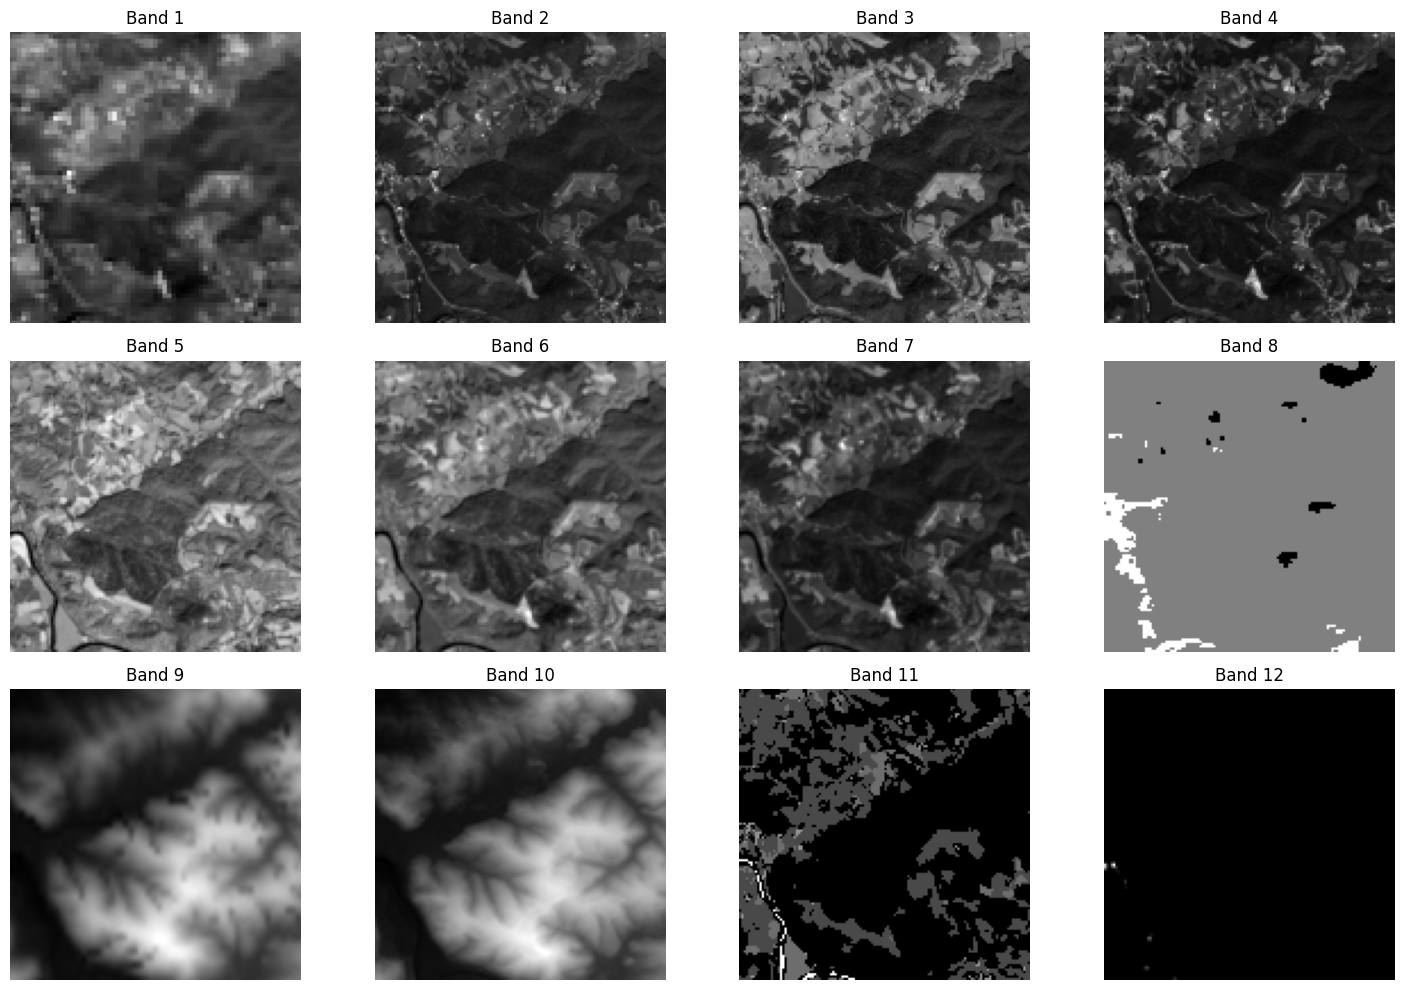

In [38]:
import rasterio
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        image = image.astype('float32')
    return image


image_path = '/kaggle/input/rfeethhetn/data/images/1.tif'
image = load_image(image_path)


fig, axes = plt.subplots(3, 4, figsize=(15, 10))  
axes = axes.flatten() 

# Plot each band
for i in range(12):
    ax = axes[i]
    ax.imshow(image[i], cmap='gray')
    ax.set_title(f'Band {i+1}')
    ax.axis('off')  # Hide the axes

# Remove any unused subplots
for j in range(12, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [7]:
image_path = '/kaggle/input/rfeethhetn/data/images/0.tif'

# Open the image file
with rasterio.open(image_path) as img_src:
    # Read the image data
    image = img_src.read()

    min_val = image[4].min()
    max_val = image[4].max()

min_val,max_val

(46, 4975)

In [8]:
def normalize_band(band, min_val, max_val):
    if max_val != min_val:
        normalized_band = (band - min_val) / (max_val - min_val)
    else:
        normalized_band = np.zeros_like(band)
    return normalized_band

def replace_nan_with_value(array):
    # Replace NaNs with a specific value
    array[np.isnan(array)] = 0
    return array

# Load and normalize images
images = []
labels = []

for img_name in sorted(os.listdir(image_dir)):
    img_path = os.path.join(image_dir, img_name)
    with rasterio.open(img_path) as img_src:
        image = img_src.read()  # Read all bands
        # Normalize each band individually
        normalized_image = np.zeros_like(image, dtype='float32')
        for band_idx in range(image.shape[0]):
            band = image[band_idx]
            min_val = np.nanmin(band)  # Use np.nanmin to handle NaN values
            max_val = np.nanmax(band)  # Use np.nanmax to handle NaN values
            band = replace_nan_with_value(band)  # Replace NaNs in the band
            normalized_image[band_idx] = normalize_band(band, min_val, max_val)
        # Transpose to (height, width, bands)
        normalized_image = np.transpose(normalized_image, (1, 2, 0))
        images.append(normalized_image)

# Load and normalize labels
for lbl_name in sorted(os.listdir(label_dir)):
    if '_' in lbl_name:
        continue

    lbl_path = os.path.join(label_dir, lbl_name)
    label = Image.open(lbl_path)
    label_array = np.array(label).astype('float32')
    label_array = np.expand_dims(label_array, axis=-1)
    labels.append(label_array)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print shapes
print("Shape of images array:", images.shape)
if len(images) > 0:
    print("Shape of the first image:", images[0].shape)

print("Shape of labels array:", labels.shape)
if len(labels) > 0:
    print("Shape of the first label:", labels[0].shape)

Shape of images array: (306, 128, 128, 12)
Shape of the first image: (128, 128, 12)
Shape of labels array: (306, 128, 128, 1)
Shape of the first label: (128, 128, 1)


In [9]:
print(images[0].shape) 

(128, 128, 12)


In [10]:
images.min(),images.max()

(0.0, 1.0)

In [11]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.25, random_state=42)

In [12]:
test_images, val_images, test_labels, val_labels = train_test_split(val_images, val_labels, test_size=0.5, random_state=42)

In [13]:
import keras
# or from tensorflow import keras

keras.backend.set_image_data_format('channels_last')

In [22]:
!pip install torch-adopt

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 9.0 MB/s eta 0:00:000:00:0100:01
   ━━

AttributeError: 'Functional' object has no attribute 'parameters'

In [14]:
!pip install segmentation-models

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00


In [17]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'  # Set to TensorFlow framework
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

# Pre-trained U-Net with EfficientNetB0 
model = Unet(
    backbone_name='efficientnetb0',  # Pre-trained encoder
    encoder_weights='imagenet',     # Use ImageNet-pretrained weights
    encoder_freeze=False          
)

for layer in model.layers[:100]:  
    layer.trainable = False

# Unfreeze the last 2-3 blocks of the encoder
for layer in model.layers[100:]:  
    layer.trainable = True

# Ensure decoder layers are trainable
for layer in model.layers:
    if 'decoder' in layer.name:  
        layer.trainable = True



# Custom Input for 12-channel data
inp = Input(shape=(128, 128, 12))  # Input shape with 12 channels
l1 = Conv2D(3, (1, 1))(inp)        # Map 12 channels to 3 channels

# Pass through the pre-trained U-Net
out = model(l1)

# Compile the model
model = Model(inputs=inp, outputs=out)
model.compile(
    optimizer='adam',
    loss=bce_jaccard_loss,         # Loss function
    metrics=[iou_score]            # IoU metric
)

In [42]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 3)         │              39 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_18 (Functional)           │ (None, 128, 128, 1)         │      10,115,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,115,540 (38.59 MB)

 Trainable params: 9,826,420 (37.48 MB)

 Non-trainable params: 289,120 (1.10 MB)

In [43]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True)

In [49]:
model_filepath = "/kaggle/working/modellll-{epoch:02d}-{val_iou_score:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_iou_score',  # Monitor the IoU score
    mode='max',
    save_best_only=True,
    verbose=1
)


In [50]:
history = model.fit(train_images, 
                    train_labels, 
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=32,
                   callbacks=[early_stopping,checkpoint, reduce_lr]) 

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - iou_score: 0.8178 - loss: 0.2921 - val_iou_score: 0.6807 - val_loss: 0.5461 - learning_rate: 2.5000e-04
Epoch 2/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - iou_score: 0.8361 - loss: 0.2593

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - iou_score: 0.8297 - loss: 0.2843 - val_iou_score: 0.6597 - val_loss: 0.5969 - learning_rate: 2.5000e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - iou_score: 0.8142 - loss: 0.3050 - val_iou_score: 0.6889 - val_loss: 0.5292 - learning_rate: 2.5000e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - iou_score: 0.8179 - loss: 0.2976 - val_iou_score: 0.6966 - val_loss: 0.5168 - learning_rate: 2.5000e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - iou_score: 0.8139 - loss: 0.2806 - val_iou_score: 0.6964 - val_loss: 0.5204 - learning_rate: 2.5000e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - iou_score: 0.8277 - loss: 0.2754 - val_iou_score: 0.7038 - val_loss: 0.5148 - learning_rate: 2.5000e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - iou_score: 0.8302 - loss: 0.2749 - val_iou_score: 0.6964 - val_loss: 0.5359 - learning_rate: 2.5000e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - iou_score: 0.8321

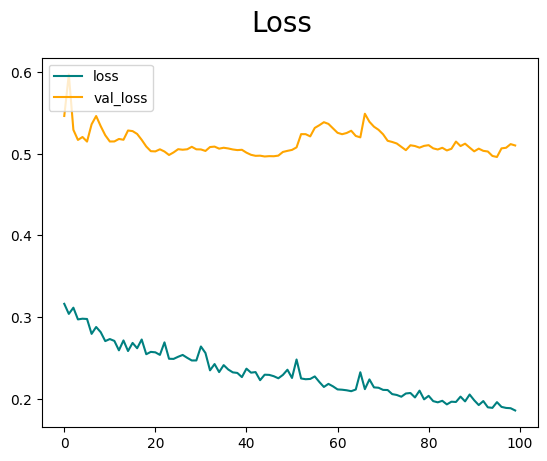

In [51]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [52]:
fig = plt.figure()
plt.plot(history.history['binary_accuracy'], color='teal', label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], color='orange', label='val_binary_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

KeyError: 'binary_accuracy'

<Figure size 640x480 with 0 Axes>

In [53]:
def compute_iou(y_true, y_pred, class_label=1):
    intersection = np.logical_and(y_true == class_label, y_pred == class_label).sum()
    union = np.logical_or(y_true == class_label, y_pred == class_label).sum()
    iou = intersection / union if union != 0 else 0
    return iou

In [54]:
def compute_precision(y_true, y_pred, class_label=1):
    true_positive = np.logical_and(y_true == class_label, y_pred == class_label).sum()
    predicted_positive = (y_pred == class_label).sum()
    precision = true_positive / predicted_positive if predicted_positive != 0 else 0
    return precision

In [55]:
def compute_recall(y_true, y_pred, class_label=1):
    true_positive = np.logical_and(y_true == class_label, y_pred == class_label).sum()
    actual_positive = (y_true == class_label).sum()
    recall = true_positive / actual_positive if actual_positive != 0 else 0
    return recall

In [56]:
def compute_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

In [57]:
new_model= load_model("/kaggle/working/modell-22-0.9185.keras")

ValueError: File not found: filepath=/kaggle/working/modell-22-0.9185.keras. Please ensure the file is an accessible `.keras` zip file.

In [58]:
test_labels[5]

array([[[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [59]:
predictions = model.predict(test_images)
binary_prediction = (predictions > 0.5).astype(int)
predictions = binary_prediction.astype('float32')


iou_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(len(test_labels)):
    y_true = test_labels[i].squeeze()  # Squeeze to remove extra dimensions
    y_pred = predictions[i]
    y_pred = np.squeeze(y_pred)
    
    iou = compute_iou(y_true, y_pred, class_label=1)
    precision = compute_precision(y_true, y_pred, class_label=1)
    recall = compute_recall(y_true, y_pred, class_label=1)
    f1_score = compute_f1_score(precision, recall)

    iou_scores.append(iou)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1_score)

# Compute average scores
avg_iou = np.mean(iou_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1= np.mean(f1_scores)

avg_iou,avg_precision,avg_recall,avg_f1

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 9s/step


(0.6240042595948341,
 0.7491805726162677,
 0.6855230872490103,
 0.6974585126575467)

In [ ]:
y_true.shape,y_pred.shape

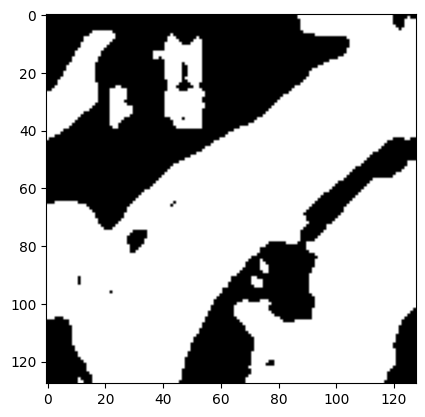

In [61]:
plt.imshow(predictions[4], cmap='gray')
plt.show()

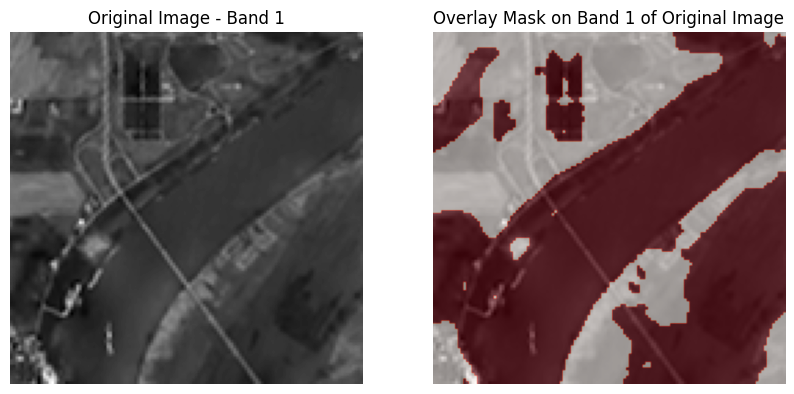

In [62]:
plt.figure(figsize=(10, 5))

# Plot the first band of the original image
plt.subplot(1, 2, 1)
plt.imshow(test_images[4][:, :, 0], cmap='gray')
plt.title('Original Image - Band 1')
plt.axis('off')

# Plot the overlay mask on the same image
plt.subplot(1, 2, 2)
plt.imshow(test_images[4][:, :, 0], cmap='gray') #(R,C,Dimentions)
plt.imshow(predictions[4], cmap='Reds', alpha=0.5)
plt.title('Overlay Mask on Band 1 of Original Image')
plt.axis('off')

plt.show()